# Delta Hes Model
Based on these equations: 

$$\frac{dH_i}{dt} = \beta_H m_{h,i}(t-T_p) - \gamma_H H_i(t)$$

$$\frac{dm_{H,i}}{dt} = \beta_m(w_H \frac{p_H^l}{p_H^l + H_i(t-T_m)^l} + w_D \frac{<D(t-T_m)>_i^n}{p_D^n + <D(t-T_m)>_i^n}) - \gamma_m m_{H,i}(t)$$

$$\frac{dD_i}{dt} = \beta_D m_{D,i}(t-T_p) - \gamma_D D_i(t)$$

$$\frac{dm_{D,i}}{dt} = \beta_m \frac{p_H^l}{p_H^l + H_i(t-T_m)^l} - \gamma_m m_{H,i}(t)$$

Using non-dimensionalisation:
- $H_i = \tilde H h_i$ --> $\tilde H = p_H$
- $D_i = \tilde D d_i$ --> $\tilde D = p_D$
- $m_{H,i} = \tilde {m}_H m_{h,i}$ --> $\tilde m_H = \frac{\beta_m}{\gamma_m}$
- $m_{D,i} = \tilde {m}_D m_{d,i}$  --> $\tilde m_D = \frac{\beta_m}{\gamma_m}$
- $ t = \tilde t \tau$ --> $\tilde t = \gamma_m^{-1}$

and the following parameters: 
- $\alpha_H = \frac{\beta_H \beta_m}{\gamma_H \gamma_m p_H}$ 
- $\alpha_D = \frac{\beta_D \beta_m}{\gamma_D \gamma_m p_D}$
- $\mu = \frac{\gamma_H}{\gamma_m}$ 
- $\nu = \frac{\gamma_D}{\gamma_m}$

This gave me the following non-dimensionalised equations: 

$$\frac{d h_i}{d \tau} = \mu (\alpha_H m_{h,i}(\tau - \tau_p) - h_i(\tau))$$
$$\frac{dm_{h,i}}{d \tau} = w_H \frac{1}{1 + h_i(\tau-\tau_m)^l} + w_D \frac{<d(\tau-\tau_m)>_i^n}{1 + <d(\tau-\tau_m)>_i^n} - m_{h,i}(\tau)$$
$$\frac{d d_i}{d \tau} = \nu (\alpha_D m_{d,i}(\tau - \tau_p) - d_i(\tau))$$
$$\frac{dm_{d,i}}{d\tau} = \frac{1}{1 + h_i(\tau-\tau_m)^l} - m_{h,i}(\tau)$$

Note $\tau_p = \frac{T_p}{\tilde t}$ and $\tau_m = \frac{T_m}{\tilde t}$

In [104]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#import visualisation as vis

In [112]:
def calculate_nondimensional_params(beta_H, beta_D, beta_m, gamma_H, gamma_D, gamma_m, p_H, p_D, T_p, T_m, w_H, w_D, l, n):
    """Calculates non-dimensional parameters from physical parameters."""
    return SimpleNamespace(
        alpha_H = (beta_H * beta_m) / (gamma_H * gamma_m * p_H),
        alpha_D = (beta_D * beta_m) / (gamma_D * gamma_m * p_D),
        mu = gamma_H / gamma_m,
        nu = gamma_D / gamma_m,
        tau_p = T_p * gamma_m,
        tau_m = T_m * gamma_m,
        w_H = w_H,
        w_D = w_D,
        l = l,
        n = n
    )

def get_params(beta_H, beta_D, beta_m, gamma_H, gamma_D, gamma_m, p_H, p_D, T_p, T_m, w_H, w_D, l, n, lattice, tau_grad = True, tau_grad_strength = 0.5):
    """Returns a SimpleNamespace containing model parameters calculated from physical parameters."""
    params_nondim = calculate_nondimensional_params(beta_H, beta_D, beta_m, gamma_H, gamma_D, gamma_m, p_H, p_D, T_p, T_m, w_H, w_D, l, n)
    params_nondim.tau_grad = tau_grad
    params_nondim.tau_grad_strength = tau_grad_strength
    
    if tau_grad:
        # add a gradient in tau_p due to the FGF gradient
        params_nondim.tau_p = tau_grad_strength * np.arange(0, lattice.P) + params_nondim.tau_p #assume linear gradient with offset tau_p
        params_nondim.tau_m = params_nondim.tau_m * np.ones(lattice.P) #assume no gradient in tau_m

    return params_nondim


def get_lattice(P, Q):
    lattice = SimpleNamespace()
    # get sizes of the system 
    lattice.P = P            # length of PSM + tailbud
    lattice.Q = Q            # diameter (2D so width) of PSM and tailbud, if Q = 1 then we have 1D system

    # define the weights, connectivity matrix and coupling strength between the cells 
    if lattice.Q > 1:
        lattice.w = 4        # weight if each cell has 4 neighbours 
    else:
        
        lattice.w = 2*np.ones(P)
        lattice.w[0] = 1        # weight of first and last cell is only 1
        lattice.w[-1] = 1        

    lattice.connectivity = connectivitymatrix(lattice.P, lattice.Q)    # connectivity matrix 
    return lattice

def getIC(params, lattice):
    '''Get initial conditions for the system with noise term'''

    U = np.random.uniform(0,1,[lattice.P, lattice.Q]) - 1/2                              #a uniform random distribution
    epsilon = 1e-5                                                  #multiplicative factor of Delta initial condition
    D0 = epsilon*params.betaD*(1 + params.sigma*U)                  #initial Delta levels 
    R0 = np.zeros([lattice.P, lattice.Q])                                                #initial repressor levels

    initial = np.append(D0, R0)                                     #matrix of initial conditions                                          
    
    return initial

def connectivitymatrix(P, Q):
    '''Calculates the connectivity matrixs'''
    k = P*Q                 # number of cells 
    M = np.zeros([k,k])     # connectivity matrix

    # calculating the connectivity matrix

    for i in range(k):
        i_neighbour = findneigbours(i, P, Q)

        # check if the neighbours are within the range of the system
        for j in i_neighbour:
            if 0 <= j:
                M[i, j] = 1
    
    return M   

def findneigbours(index, P, Q):
    '''Finds neighbours of cell with index for system of P, Q cells'''
    
    # finding neighbours for line of cells
    if Q == 1:
        left = int(index - 1)
        right = int(index + 1)

        # check if the cell is on the edge of the system
        if index % P == 0:
            left = -1
        if index % P == P - 1:
            right = -1

        neighbours = [left, right]   
    # finding neighbours for 2D system of cells
    elif Q > 1: 

        left = index - 1
        right = index + 1
        up = index - P
        down = index + P

        # check if the cell is on the edge of the system
        if index % P == 0:
            left = -1
        if index % P == P - 1:
            right = -1
        if index < P:
            up = -1
        if index >= P*(Q-1):
            down = -1
        neighbours = [left, right, up, down]
                
    else: 
        print('Q should be at least 1')

    return neighbours

def hill_function_positive(x, params):
    """Non-dimensionalized Hill function with exponent l."""
    return x**params.l / (1 + x**params.l)

def hill_function_negative(x, params):
    """Non-dimensionalized Hill function with exponent n."""
    return 1 / (1 + x**params.n)

def get_delayed_value(values_array, current_index, delay_steps):
    """Retrieves the value from a past step in the simulation."""
    delayed_index = max(0, current_index - delay_steps)
    return values_array[delayed_index]

def get_delayed_value(values_array, current_index, delay_steps, lattice, params):
    """Retrieves the value from a past step in the simulation."""

    values_delayed = values_array.copy()

    if params.tau_grad:
        for p in range(lattice.P):
            delayed_index = max(0, current_index - delay_steps[p])
            values_delayed[current_index, p, :] = values_array[delayed_index, p, :]
    
    else:
        delayed_index = max(0, current_index - delay_steps)
        values_delayed[current_index] = values_array[delayed_index]

    return values_delayed

def d_neighbours(d, lattice):
    #print(d.shape)
    d_neighbours = np.sum(lattice.connectivity * d, axis=0)/lattice.w
    #print(d_neighbours.shape)
    d_neighbours = d_neighbours.reshape(lattice.P, lattice.Q)

    return d_neighbours

def Euler(x, dx_dt, dt):
    x_new = x + dx_dt*dt
    return x_new

def dh_dt(h, m_h_tau_p, params):
    """ODE for dh/dtau with time delay."""
    return params.mu * (params.alpha_H * m_h_tau_p - h)

def dmh_dt(h, h_tau_m, d_tau_neighbours, params, lattice):
    """ODE for dm_h/dtau with time delay."""
    return params.w_H * hill_function_negative(h_tau_m, params) + params.w_D * hill_function_positive(d_tau_neighbours, params) - h

def dd_dt(d, m_d_tau_p, params):
    """ODE for dd/dtau with time delay."""
    return params.nu * (params.alpha_D * m_d_tau_p - d)

def dmd_dt(m_h, h_tau_m, params):
    """ODE for dm_d/dtau with time delay."""
    return hill_function_negative(h_tau_m, params) - m_h



In [113]:
#set the lattice of the cells 
P = 20 
Q = 1

lattice = get_lattice(P, Q)

In [122]:
# set initial parameters of the reactions 
beta_H = 5
beta_D = 5
beta_m = 1
gamma_H = 1
gamma_D = 1
gamma_m = 1
p_H = 1
p_D = 1
T_p = 5
T_m = 2
w_H = 0.1
w_D = 0.9
l = 3
n = 3

params = get_params(beta_H, beta_D, beta_m, gamma_H, gamma_D, gamma_m, p_H, p_D, T_p, T_m, w_H, w_D, l, n, lattice, tau_grad_strength=0.5)

print(params)

namespace(alpha_H=5.0, alpha_D=5.0, mu=1.0, nu=1.0, tau_p=array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
       10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5]), tau_m=array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.]), w_H=0.1, w_D=0.9, l=3, n=3, tau_grad=True, tau_grad_strength=0.5)


In [123]:
# set initial conditions of the system
U = np.random.uniform(0,1,[lattice.P, lattice.Q]) - 1/2      #a uniform random distribution
epsilon = 1e-5
sigma = 0.2
                                                  #multiplicative factor of Delta initial condition
d0 = epsilon*(1 + sigma*U)  
h0 = np.zeros([lattice.P, lattice.Q])
m_h0 = np.zeros([lattice.P, lattice.Q])
m_d0 = np.zeros([lattice.P, lattice.Q])

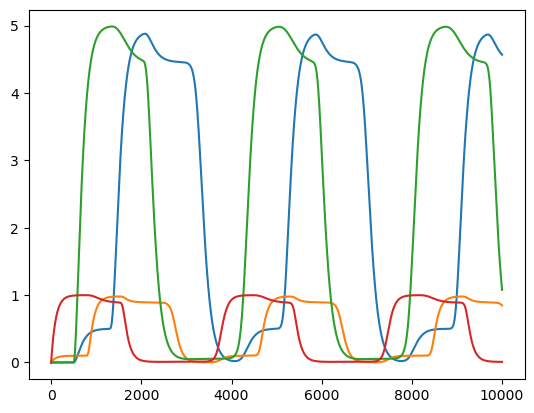

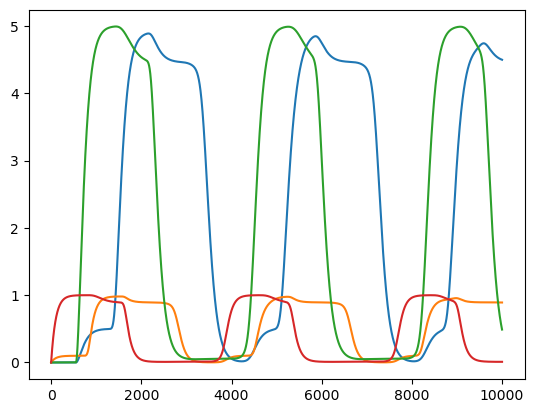

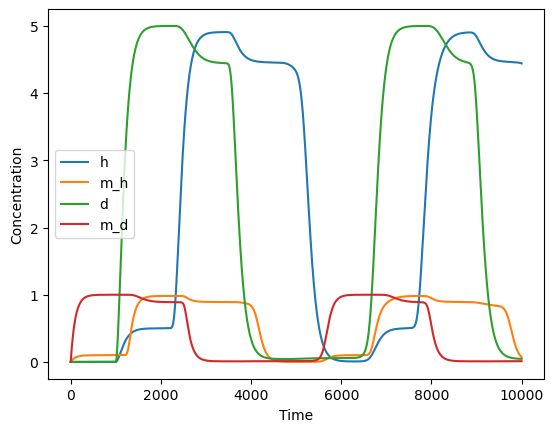

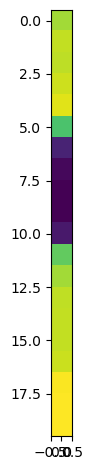

In [ ]:
num_tsteps = 10000
dt = 0.01 

h = np.zeros([num_tsteps, lattice.P, lattice.Q])
m_h = np.zeros([num_tsteps, lattice.P, lattice.Q])
m_d = np.zeros([num_tsteps, lattice.P, lattice.Q])
d = np.zeros([num_tsteps, lattice.P, lattice.Q])

h[0] = h0
m_h[0] = m_h0
m_d[0] = m_d0
d[0] = d0

for i in range(int(num_tsteps-1)):
    
    params.tau_p_steps = np.round(params.tau_p / dt).astype(int)
    params.tau_m_steps = np.round(params.tau_m / dt).astype(int)

    m_h_tau_p = get_delayed_value(m_h, i, params.tau_p_steps, lattice, params)
    m_d_tau_p = get_delayed_value(m_d, i, params.tau_p_steps, lattice, params)
    h_tau_m = get_delayed_value(h, i, params.tau_m_steps, lattice, params)
    d_tau_m = get_delayed_value(d, i, params.tau_m_steps, lattice, params)
    d_tau_neighbours = d_neighbours(d_tau_m[i,:,:], lattice)

    # calculate the values of the next time step
    h[i+1,:,:] = Euler(h[i,:,:], dh_dt(h[i,:,:], m_h_tau_p[i,:,:], params), dt)
    m_h[i+1,:,:] = Euler(m_h[i,:,:], dmh_dt(m_h[i,:,:], h_tau_m[i,:,:], d_tau_neighbours, params, lattice), dt)
    d[i+1,:,:] = Euler(d[i,:,:], dd_dt(d[i,:,:], m_d_tau_p[i,:,:], params), dt)
    m_d[i+1,:,:] = Euler(m_d[i,:,:], dmd_dt(m_d[i,:,:], h_tau_m[i,:,:], params), dt)

plt.figure()
plt.plot(h[:,10,0], label = 'h')
plt.plot(m_h[:,10,0], label = 'm_h')
plt.plot(d[:,10,0], label = 'd')
plt.plot(m_d[:,10,0], label = 'm_d')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()




(10000, 20)


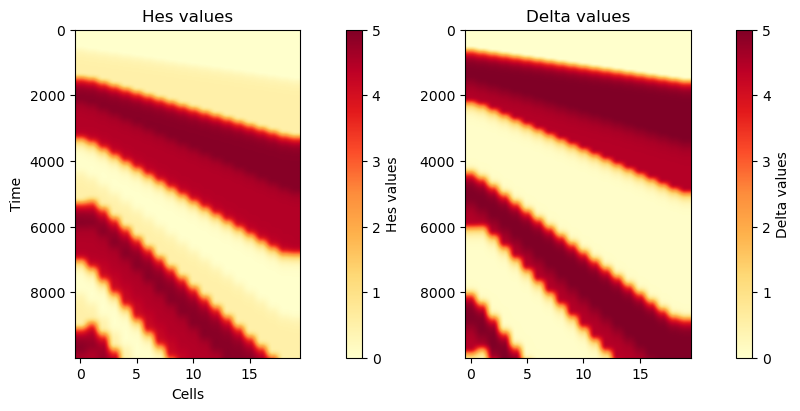

In [131]:
# Set up the figure and two axes for vertically stacked images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
h_flat = h.reshape(num_tsteps, lattice.P)
d_flat = d.reshape(num_tsteps, lattice.P)
print(h_flat.shape)

# Plot the first image
im1 = ax1.imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h), vmax = np.ceil(np.max(h)))
ax1.set_ylabel('Time')
ax1.set_xlabel('Cells')
ax1.set_title('Hes values')

# Add colorbar for the first image
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.1, pad=0.2)
cbar1.set_label('Hes values')

# Plot the second image
im2 = ax2.imshow(d_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(d), vmax = np.ceil(np.max(d)))
ax2.set_title('Delta values')

# Add colorbar for the second image
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.1, pad=0.2)
cbar2.set_label('Delta values')

In [111]:
# def get_delayed_value(values_array, current_index, delay_steps, lattice, params):
#     """Retrieves the value from a past step in the simulation."""

#     values_delayed = values_array.copy()

#     if params.tau_grad:
#         for p in range(lattice.P):
#           #  values_p = values_array[:, p, :] 
#             delayed_index = max(0, current_index - delay_steps[p])
#             print('current index is', current_index, 'at p = ', p, 'with a delay of', delay_steps[p], 'gives delayed index', delayed_index)
#             values_delayed[current_index, p, :] = values_array[delayed_index, p, :]
    
#     else:
#         delayed_index = max(0, current_index - delay_steps)
#         values_delayed[current_index] = values_array[delayed_index]

#     return values_delayed

# params_test = params 
# lattice_test = lattice
# lattice_test.P = 3

# test_matrix = np.random.rand(10, 3, 1)
# test_delays = np.array([3,3,3])

# for i in range(10):
#     delayed_test_matrix = get_delayed_value(test_matrix, i, test_delays, lattice_test, params)

#     # small fluctuation added to the test matrix
#     test_matrix[i] = test_matrix[i] + np.ones([3,1])

#     #print the values of the test matrix and the delayed test matrix
#     print(test_matrix[i], delayed_test_matrix)
